<a href="https://colab.research.google.com/github/branndonm1/branndonm1/blob/main/1D_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import packages needed
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import math


# Generating Toy Data

The code below generates a training data set of the form
$D = \{(x,y)\}_{i=1}^N$ where $x_i\sim U(-a,a)$ and $y_i = (x_i)^2+\eta e_i$ where $e_i \sim N(0,1)$ and $\eta$ is an adjustable "noise level".

Here are the first five xs: [-3.332493305206299, -8.439718246459961, 0.8323168754577637, -5.942164421081543, -5.839787483215332]
Here are the first five ys: [11.172748565673828, 73.26313018798828, 0.8957319259643555, 36.33146286010742, 33.77390670776367]

Below is a plot the whole training data set of pairs (x,y)


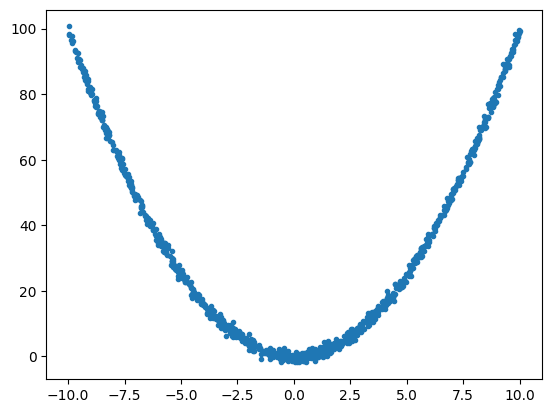

In [2]:
# Generates training data

td_size=1000 #specifies cardinality of training data set.
input_dim = 1 #specifies dimension for x's (domain) of data set.
output_dim = 1 #since f is scalar valued, label dimension is always 1.
noise_level = 1 #multiplicative constant to adjust size of noise
a_endpoint = 10 #unfiorm draws from U(-a,a)
x_train = torch.FloatTensor(td_size, input_dim).uniform_(-a_endpoint, a_endpoint)  # [[x^1],...,[x^N]] where x^i=(x_1^i,...x_N^i) are in d-dimensional space, tensor of input points of shape (n_samples, input_dim)
noise_matrix = noise_level * torch.randn(td_size,output_dim) # eta*[[e_1],...,[e_N]] where e_i are 1D scalars
f_train = torch.pow(x_train,2)+noise_matrix  # [[f(x_1)],...,[f(x_N)]] where f(x_i)=(x_i)^2+eta*e_i, # f_train is the function values for those points of shape (n_samples, output_dim)



print("Here are the first five xs: "+str([float(x) for x in x_train[0:5]]))
print("Here are the first five ys: "+str([float(x) for x in f_train[0:5]]))

print("\nBelow is a plot the whole training data set of pairs (x,y)")
plt.plot(x_train.detach().numpy(), f_train.detach().numpy(), '.')
plt.show()

# Defining model space and training to find optimal model $f(x;\theta^*)$

The code defines the form for a neural network given by
$$f(\theta;x)=A_3ReLu(A_2ReLu(A_1x+b_1)+b_2)+b_3$$
where by definition $ReLu(x)=\max(0,x)$ and $\theta=(a_i,b_i)$.

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


The code below defines a particular function $f$ with the structure above but specifically with input dimension input_dim, with hidden layer size hidden_dim. and output dimension output_dim. Then trains on the training data by minimizing (using adam algorithm) the MSE loss functional given by $R(\theta)=\frac{1}{N}\sum_{x_i} L(x_i;\theta)=\frac{1}{N} \sum_{x_i} (y(x_i)-f(x_i;\theta))^2$. Here the loss metric is $L(x;\theta)=(y(x)-f(x;\theta))^2$ where $y(x)$ is the true function value and $f(x;\theta)$ is the approximate function value. The training loops find the optimal model $f(x;\theta^*)$.

Epoch 100/1000, Loss: 887.9966430664062
Epoch 200/1000, Loss: 144.53868103027344
Epoch 300/1000, Loss: 118.05351257324219
Epoch 400/1000, Loss: 86.66361236572266
Epoch 500/1000, Loss: 57.669708251953125
Epoch 600/1000, Loss: 39.32368087768555
Epoch 700/1000, Loss: 31.401859283447266
Epoch 800/1000, Loss: 26.07000732421875
Epoch 900/1000, Loss: 20.55567169189453
Epoch 1000/1000, Loss: 16.173707962036133


Here are the first five xs: [-3.332493305206299, -8.439718246459961, 0.8323168754577637, -5.942164421081543, -5.839787483215332]
Here are the first five f(x;theta*)s: [12.592397689819336, 69.4577865600586, -2.2733914852142334, 40.272579193115234, 39.07625198364258]

\Below is a plot the optimal function over the training data points, i.e. (x,f(x;theta*))


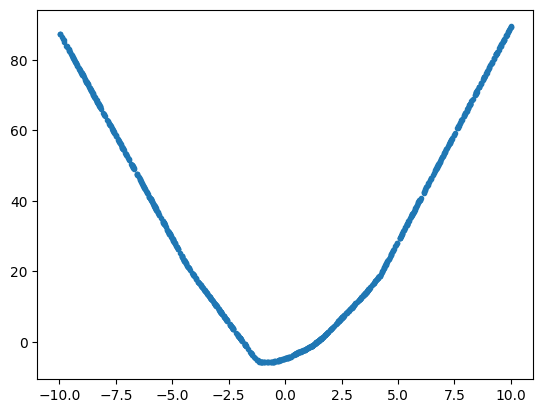

In [4]:
#fit NN with data to get f(\theta_opt;x)

# Initialize the neural network, loss function, and optimizer
hidden_dim = 32
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
l = []

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = loss_function(outputs, f_train)
    loss.backward()  # Backpropagate to compute gradients
    optimizer.step()  # Update the weights
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

print("\n\nHere are the first five xs: "+str([float(x) for x in x_train[0:5]]))
print("Here are the first five f(x;theta*)s: "+str([float(x) for x in model(x_train)[0:5]]))

print("\n\Below is a plot the optimal function over the training data points, i.e. (x,f(x;theta*))")
plt.plot(x_train.detach().numpy(), model(x_train).detach().numpy(), '.')
plt.show()

# Computing an approximation for the derivative of the loss function $L'(x;\theta^*)$

The code below determine the points $\{(x_i,L(x_i,\theta^*))\}$ where $x_i$ are from the training data

Here are the first five xs: [-3.332493305206299, -8.439718246459961, 0.8323168754577637, -5.942164421081543, -5.839787483215332]
Here are the first five L(x;theta*)s: [2.0154037475585938, 14.480640411376953, 10.043343544006348, 15.532398223876953, 28.114866256713867]

Below is a plot the the training x values vs the loss function values for the optimal model f* - i.e. points (x,L(x;theta*))


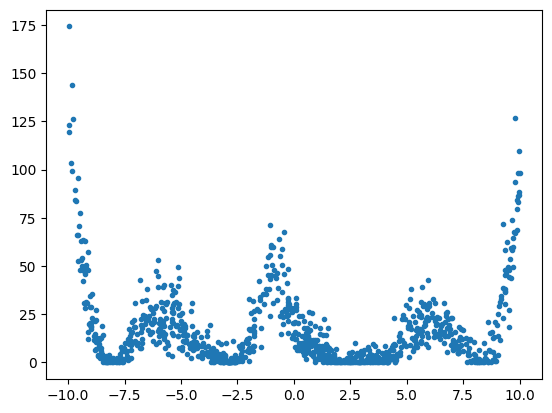

In [5]:
#only know L(\theta^*,x) for x_i in training data. Cant compute L(\theta^*,x_i) = (f(x_i)-y_i)^2 for non training data because dont have y_i lebels for every point in the domain, only for x_i.

losses = (model(x_train)-f_train)**2

print("Here are the first five xs: "+str([float(x) for x in x_train[0:5]]))
print("Here are the first five L(x;theta*)s: "+str([float(x) for x in losses[0:5]]))

#Plot of L(\theta^*, x) for x_i in training data
print("\nBelow is a plot the the training x values vs the loss function values for the optimal model f* - i.e. points (x,L(x;theta*))")
plt.plot(x_train.detach().numpy(), losses.detach().numpy(), '.')
plt.show()

Approximate derivative of $L$ over training data $x_i$ via centered difference:
$$L_x(x_i;\theta^*) \approx \frac{L(x_{i+1};\theta^*)-L(x_{i-1};\theta^*)}{x_{i+1}-x_{i-1}}$$

Here are the first five xs: [-9.979049682617188, -9.971847534179688, -9.957871437072754, -9.889162063598633, -9.842750549316406]
Here are the first five L'(x;theta*)s: [-7068.01171875, -2592.3212890625, -241.2918701171875, 211.5858917236328, -52.472442626953125]

Below is a plot the the training x values vs the apprximate loss function derivative values for the optimal model f* - i.e. points (x,L'(x;theta*))


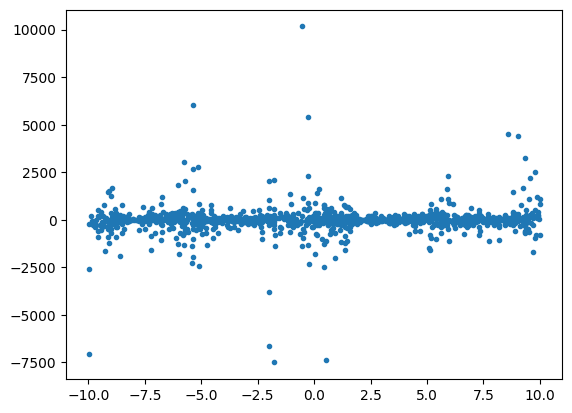

In [6]:
#derivative by center difference approximation method
def approximate_derivative(inputs, outputs):
    # Check if the tensors have the same size
    #if inputs.size(0) != outputs.size(0):
        #raise ValueError("Inputs and outputs must have the same length")

    # Ensure inputs and outputs are tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Initialize the derivative tensor with zeros
    derivatives = torch.zeros_like(outputs)

    # Central difference for the interior points
    for i in range(1, len(inputs) - 1):
        dx = inputs[i+1] - inputs[i-1]
        dy = outputs[i+1] - outputs[i-1]
        derivatives[i] = dy / dx

    # Forward difference for the first point
    derivatives[0] = (outputs[1] - outputs[0]) / (inputs[1] - inputs[0])

    # Backward difference for the last point
    derivatives[-1] = (outputs[-1] - outputs[-2]) / (inputs[-1] - inputs[-2])

    return derivatives

#have to short inputs so they are increasing and center difference formula is valid to use
xs, xind = torch.sort(x_train.squeeze())
xs = [[x] for x in xs]
ys = [losses[i] for i in xind]

app_deriv = approximate_derivative(xs,ys) #compute app derivative with sorted data


print("Here are the first five xs: "+str([float(x[0]) for x in xs[0:5]]))
print("Here are the first five L'(x;theta*)s: "+str([float(x) for x in app_deriv[0:5]]))

#Plot of L'(theta^*;x) approximation over training data x_i
print("\nBelow is a plot the the training x values vs the apprximate loss function derivative values for the optimal model f* - i.e. points (x,L'(x;theta*))")
plt.plot(xs, app_deriv , '.')
plt.show()

Since approximate $L'(\theta^*;x)$ is rough, we will smooth is out to produce an approximation $L'_s(\theta^*;x)$ where s stands for smoothed derivative approximation.

The code below replaces the labels $\{y_i\}$ with labels $\{y'_i\}$ where the new labels of the form $$y'_i=\sum_{j=-a}^a y_jK(i-j)$$
and $K$ is the gaussian kernel
$$K(x)=\frac{1}{\sqrt{2\sigma\pi}}e^{-\frac{x^2}{2\sigma^2}}$$

Here are the first five xs: [-9.979049682617188, -9.971847534179688, -9.957871437072754, -9.889162063598633, -9.842750549316406]
Here are the first five L_s'(x;theta*)s: [-282.5097961425781, -284.6441650390625, -308.46881103515625, -308.0614929199219, -307.4728088378906]

Below is a plot the the training x values vs the smoothed apprximate loss function derivative values for the optimal model f* - i.e. points (x,L_s'(x;theta*))


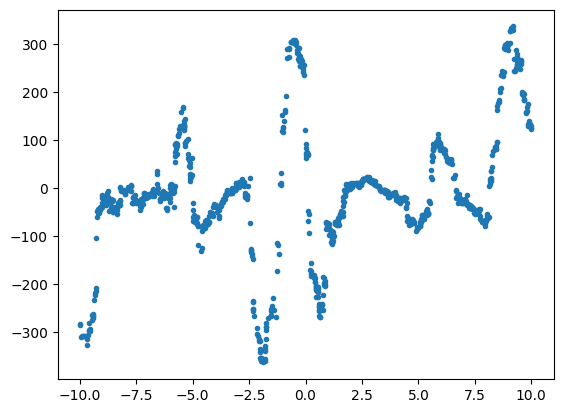

In [7]:

#defines set (x,y) where y=c e^(-x^2/2s^2) where c is normalizing constant and s is specified standard dev
def gaussian_kernel(kernel_size, sigma):
    """Create a Gaussian kernel."""
    x = torch.linspace(-sigma, sigma, kernel_size)
    kernel = torch.exp(-x**2 / (2 * sigma**2))
    kernel = kernel / kernel.sum()  # Normalize the kernel
    return kernel.view(1, 1, -1)  # Reshape for convolution

#takes some labels and and fits to linear combination of gaussian function then returns the new smoothed out labels
def gaussian_smoothing(labels, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    labels = labels.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    smoothed_labels = F.conv1d(labels, kernel, padding=kernel_size//2)
    return smoothed_labels.squeeze(0).squeeze(0)

#computes smoothed labels for L'(theta^*;x), can specify kernel size and sigma
smoothed_labels = gaussian_smoothing(app_deriv.squeeze(), kernel_size=50, sigma=1)

print("Here are the first five xs: "+str([float(x[0]) for x in xs[0:5]]))
print("Here are the first five L_s'(x;theta*)s: "+str([float(x) for x in smoothed_labels[0:5]]))

print("\nBelow is a plot the the training x values vs the smoothed apprximate loss function derivative values for the optimal model f* - i.e. points (x,L_s'(x;theta*))")
#Plots smoothed L'(theta^*;x)
plt.plot(xs, smoothed_labels[:-1] , '.')
plt.show()

# Using MCMC methods to approximate integral $Z(b;\theta)$

The reason for computing the the approximatin for the derivative of the loss function $L'(x;\theta)$ is because we need it in the MCMC methods that is used to approximate the integral $$Z(b;\theta)=\int e^{-bL(x;\theta)}\rho(x)\, dx.$$

For $\rho\equiv1$ and since the training data set is assumed to be from interval $(-a,a)$, the integral we are concerned with is $$Z(b;\theta)=\int_{-a}^a e^{-bL(x,\theta)}\, dx$$

By using a MCMC method we can approximate the integral by first apprxoiming the solution to an appropriate SPDE and then using the approximate solution to approximate the integral. In particular we will:

1.) Use Euler-Maruyama/Milstein first order method to approximate solution to
 $$\begin{cases}
    dX_t = -\partial_x L(X_t,\theta)\,dt+\frac{\sqrt{2}}{b}\, dB_t \\
    X_0 = x_0
  \end{cases}$$
  and arrive at a class of solution sequence $\{(\chi^n_t)\}_{n=1}^N$, where the terms of the n-th sequences $\chi^n_0,\chi_1^n,...,\chi_T^n$ are found by the interative scheme
  $$\chi^n_{t+1}=\chi^n_t-\Delta t\cdot L_x(\chi^n_t,\theta)+\frac{\sqrt{2}}{b}\Delta W_t \, \,; \, \, \chi_0^n=x_0^n$$
  $N$ is an arbitrary size of the initial data set to initiate the iteration from $\{x_0^1,...,x_0^N\}$. $T$ is some specified final time by the user. Then $\Delta t=\frac{T}{N}$ and $\Delta W_t \sim N(0,\frac{T}{N})$.

  2.) Once one has all the sequences $\{(\chi^n_t)\}_{n=1}^N$, one can use the set of all final time $\{\chi_T^n\}_{n=1}^N$ to approximate the integral by taking
  $$Z(b;\theta) = \int_{-a}^a e^{-bL(x,\theta)}\, dx \approx \frac{1}{\frac{1}{N}\sum_{i=1}^N e^{-bL(\chi_T^n,\theta)}}.$$
  



# MCMC Modification for Implementation

Note that we dont know the derivative $L'(x;\theta^*)$ at all $x$ values in the domain, we only know it at the values of $x$ that were in the original training data. Therefore whenever the algorithm calls for $L'(x;\theta^*)$ at an arbitrary $x$, we will simply take the values of $L'$ at the closest $x$ that is in the training data set. We define a function that find the index of the closes $x$ in training data set for any arbitrary $x$.

In [8]:
#for finding index of element whos values is closest to x in the tensor.
#Need for MCMC algorithm because to TRULY implement the algo we need to know L'(theta^*,x) at ALL values of x in the domain
#but we dont have that, we only know L' at the point x_i from the training set.
#So any time we need L'(theta;x) we simply use L'(theta,x_c) where x_c is the closet point in the training data set to x

def closest_index(tensor, x):
    # Calculate the absolute difference between each element and x
    diff = torch.abs(tensor - x)
    # Find the index of the minimum value in the difference tensor
    index = torch.argmin(diff)
    return index.item()  # return as a Python integer

x = 7.22
tensor = torch.tensor([6,6.5,-6,101,11,3.222])
index = closest_index(tensor, x)


print(f"Here is an example of how the function works. \nGiven x={x} and the tensor {tensor}, the INDEX of the closest element to {x} is {index} and has VALUE {tensor[index]}.")


Here is an example of how the function works. 
Given x=7.22 and the tensor tensor([  6.0000,   6.5000,  -6.0000, 101.0000,  11.0000,   3.2220]), the INDEX of the closest element to 7.22 is 1 and has VALUE 6.5.


# MCMC algorithm to determine the sequences $\{(\chi_t^n)\}_{n=1}^N$

In [9]:
#set parameters
N=5000
T=20
delta_t = T / N
b=random.uniform(pow(10,-20),10000)

#determined sequences
chis=torch.zeros(N,T)
for n in range(N):
  temp_x = random.uniform(-.1,.1)
  for t in range(T):
    temp_x = temp_x - delta_t*smoothed_labels[xind[closest_index(x_train, temp_x)]]+pow(2,.5)*(1/b)*np.random.normal(loc=0, scale=delta_t)
    if temp_x > a_endpoint or temp_x < -a_endpoint:
      print("x outside of range, modify parameters")
      #temp_x = x_train[closest_index(x_train, temp_x)]

    chis[n][t]=temp_x

#prints whole sequence chi_0^0, ... , chi_T^0 initiating from first initial value x_0
print("Here if the first sequences (n=1) of length T that initiated at x^1_0 = "+str(float(chis[0][0]))+": \n(chi_t^1) = "+str([str(float(x))[:8] for x in chis[0]]))

Here if the first sequences (n=1) of length T that initiated at x^1_0 = 1.0539501905441284: 
(chi_t^1) = ['1.053950', '1.560455', '1.642442', '1.950601', '2.375173', '2.674241', '2.209302', '2.375180', '2.674249', '2.209310', '2.375191', '2.674260', '2.209320', '2.375200', '2.674269', '2.209329', '2.375209', '2.674276', '2.209337', '2.375216']


# Compute the approximate for $Z(b;\theta^*)$ using finals time terms of the sequences $\{\chi_T^n\}$

In [10]:
#exponentiate sequence values
all_chis = chis.flatten()
chis_closest_index = [closest_index(x_train, all_chis[i]) for i in range(len(all_chis))]
chis_losses = torch.tensor([losses[i] for i in chis_closest_index])
chis_exp_loss = torch.exp(-b*chis_losses)
#smood = gaussian_smoothing(chis_exp_loss.squeeze(), kernel_size=20, sigma=1)

#compute integral approximation
chis_T = torch.zeros(N)
for n in range(N):
  chis_T[n] = chis[n][T-1]

chis_T_closest_index = [closest_index(x_train, chis_T[i]) for i in range(len(chis_T))]
chis_T_losses = torch.tensor([losses[i] for i in chis_T_closest_index])
chis_T_exp_loss = torch.exp(-b*chis_T_losses)
#smood = gaussian_smoothing(chis_T_exp_loss.squeeze(), kernel_size=20, sigma=1)

int_app = 1/((1/N)*torch.sum(chis_T_exp_loss))
#int_app_s = 1/((1/N)*torch.sum(smood))
print("The approxaimate integral value Z(b;theta*) is: "+str(float(int_app)))
#print(int_app_s)

The approxaimate integral value Z(b;theta*) is: 286.60003662109375


# Below are some visualizations of the MCMC data


Below is a histogram of values from the first sequence (chi_t^1):


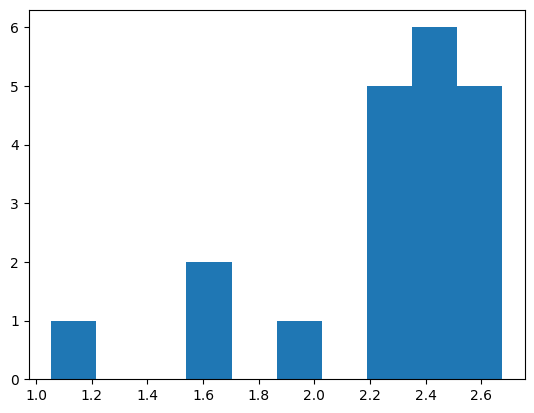


Below is a histogram of all sequences values chi (for all n and t):


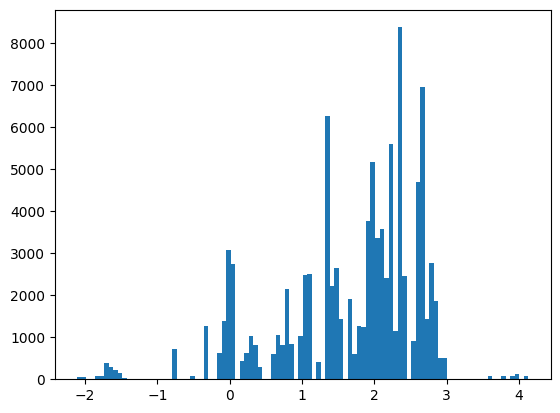



Below is a graph of all chis vs exp(-bL(chi;theta*))


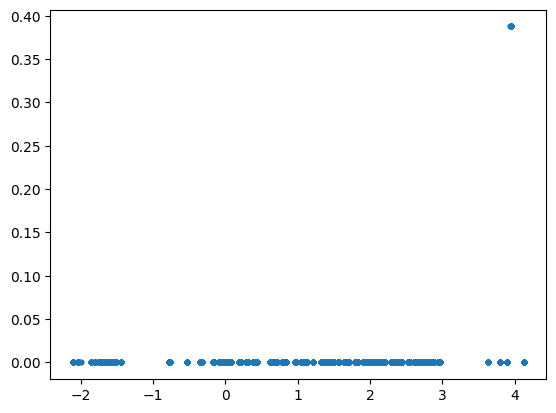

In [11]:
print("\nBelow is a histogram of values from the first sequence (chi_t^1):")
plt.hist(all_chis[:T].detach().numpy(), bins=10)
plt.show()

print("\nBelow is a histogram of all sequences values chi (for all n and t):")
plt.hist(all_chis.detach().numpy(), bins=100)
plt.show()

print("\n\nBelow is a graph of all chis vs exp(-bL(chi;theta*))")
plt.plot(all_chis.detach().numpy(), chis_exp_loss.detach().numpy() , '.')
plt.show()

# MCMC algo for multiple $b$ values to obtain asymptotic for $Z(b;\theta^*)$

In [12]:
#I now run the steps from above for several b's to get an asymptotic
# tensor that holds all MCMC data
b_list=[random.uniform(pow(10,-20),10000) for i in range(50)]
b_list.sort()
chis_asymp = torch.zeros(len(b_list),N,T) #y_s[i][n][t] has Y_t for initial condition number n for b_i in the list


#fills tensors using MCMC algorithm we derived
for i in range(len(b_list)):
  if i%10==0:
    print("working on b index "+str(i)+" with b value "+str(b_list[i]))
  for n in range(N):
    q = random.uniform(-.1, .1)
    for t in range(T):
      q = q - delta_t*smoothed_labels[xind[closest_index(x_train, q)]]+pow(2,.5)*(1/b_list[i])*np.random.normal(loc=0, scale=delta_t)
      if q > a_endpoint or q < -a_endpoint:
        print("x out of range")
        #q = x_train[closest_index(x_train, q)]
      chis_asymp[i][n][t]=q


chis_asymp_T = torch.zeros(len(b_list),N)
for i in range(len(b_list)):
  for n in range(N):
    chis_asymp_T[i][n] = chis_asymp[i][n][T-1]


#chis_asymp_b_T = torch.zeros(len(b_list))
#for i in range(len(b_list)):
#  chis_asymp_b_T[i] = torch.tensor([chis_asymp_T[i][j] for j in range(N)])
#print(chis_asymp_b_T)

chis_asymp_T_index = torch.zeros(len(b_list),N)
for i in range(len(b_list)):
  for n in range(N):
    chis_asymp_T_index[i][n] = closest_index(x_train, chis_asymp_T[i][n])

chis_asymp_T_losses = torch.zeros(len(b_list),N)
for i in range(len(b_list)):
  for n in range(N):
    chis_asymp_T_losses[i][n] = losses[int(chis_asymp_T_index[i][n])]

chis_asymp_T_exp_loss = torch.zeros(len(b_list),N)
y=chis_asymp_T_losses.detach().numpy()
for i in range(len(b_list)):
  for n in range(N):
    chis_asymp_T_exp_loss[i,n] = torch.tensor(np.exp(-b_list[i]*y[i][n]), dtype=torch.float32)



#smood_b = torch.zeros(len(b_list),N)
#for i in range(len(b_list)):
#  x = gaussian_smoothing(torch.tensor([chis_asymp_T_exp_loss[i][n] for n in range(N)]), kernel_size=20, sigma=1)
#  for n in range(N):
#    smood_b[i][n] = x[n]

int_app_b = torch.zeros(len(b_list))
for i in range(len(b_list)):
  int_app_b[i] = 1/((1/N)*torch.sum(chis_asymp_T_exp_loss[i]))


#int_app_s_b = torch.zeros(len(b_list))
#for i in range(len(b_list)):
#  int_app_s_b[i] = 1/((1/N)*torch.sum(smood_b[i]))

print("\nHere are all the b values "+str(b_list))
print("\nHere are the approximate integral values Z(b;theta*) for all the bs: "+str([float(x) for x in int_app_b]))




working on b index 0 with b value 140.51464155902303
working on b index 10 with b value 1539.6190945597855
working on b index 20 with b value 3844.155748416862
working on b index 30 with b value 5693.914025806389
working on b index 40 with b value 7018.6202364483415

Here are all the b values [140.51464155902303, 304.39460875859584, 387.9641270123224, 622.8213209389733, 792.2462430366561, 1051.0540441062199, 1208.0432847729173, 1212.2285120765775, 1239.2297883244885, 1480.6355654151614, 1539.6190945597855, 1759.7041489751198, 1840.1073290678994, 2032.6430339810374, 2074.9381699452165, 2610.603593500097, 2701.844017403632, 2993.8040849854997, 3466.556080651363, 3583.601725453761, 3844.155748416862, 3910.9165139254733, 4281.802954860543, 4302.244756674817, 4524.290952257584, 4637.1532009968705, 4837.1278362837, 4991.81435872936, 5093.82662765076, 5545.006520021665, 5693.914025806389, 5980.621633125668, 6033.120451613588, 6094.178869948724, 6129.122196923175, 6284.696067287833, 6448.28771

# Quantitative Analysis of Asymptotic Data

In [13]:
from scipy import stats

b_list = np.array(b_list)

# Step 1: Handle NaN values in torch.log(int_app_b)
log_values = torch.log(int_app_b)
log_values_np = log_values.detach().numpy()

# Mask the NaN values and filter b_list accordingly
mask = ~np.isinf(log_values_np)
b_list_clean = b_list[mask]
log_values_clean = log_values_np[mask]

# Step 2: Perform Linear Regression (Best Fit Line)
slope, intercept, r_value, p_value, std_err = stats.linregress(b_list_clean, log_values_clean)

# The equation of the line is: y = slope * x + intercept
print(f"Best fit line for the log scale graph: y = {slope} * x + {intercept}")
print(f"R-squared: {r_value**2}\n\n")

print(f"The slope on the log scale indicates that the b vs. Z(b;theta) curves goes like e^({slope}*b)")

Best fit line for the log scale graph: y = 0.00013583105118536424 * x + 4.536538453304997
R-squared: 0.7898856949951318


The slope on the log scale indicates that the b vs. Z(b;theta) curves goes like e^(0.00013583105118536424*b)


# Visualization of Asymptotic for $Z(b;\theta^*)$


Below is a plot of b vs. Z(b;theta*)


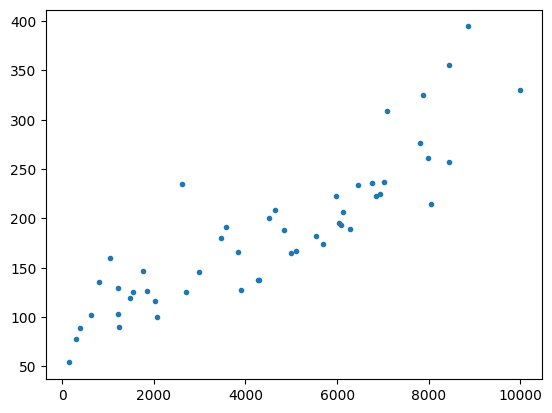


Below is a plot of b vs. ln(Z(b;theta*)) -- log scale


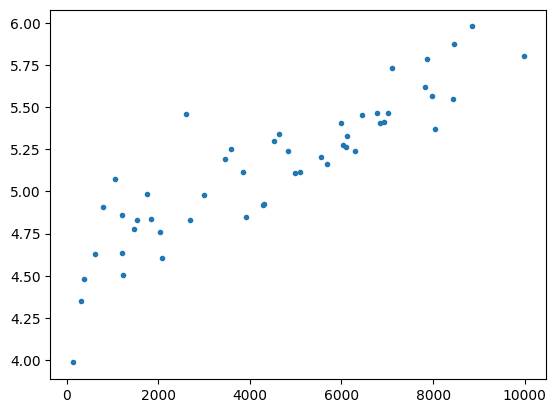

In [14]:
print("\nBelow is a plot of b vs. Z(b;theta*)")
plt.plot(b_list, int_app_b.detach().numpy() , '.')
plt.show()

print("\nBelow is a plot of b vs. ln(Z(b;theta*)) -- log scale")
plt.plot(b_list, torch.log(int_app_b).detach().numpy() , '.')
plt.show()